# Status of DC/DC converter for MOPS

In [2]:
from analysis import analysis
from analysis import plotting
import numpy as np
import logging
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(name)s - [%(levelname)-8s] (%(threadName)-10s) %(message)s")
logger = logging.getLogger(__name__)
import pandas as pd

def voltagesupply(pf= 4*5, fl = 1.2, Is=np.arange(0.1,20,0.1),Rc=4):
    '''
    The function will print the needed voltage supply from the power supply.
    Pf is FPGA power
    eff is the converter efficiency
    Is =array of all the possible currents in a specific range 
    Rc is the cable resistance as calculated from AWG
    '''
    # calculate the proposed power voltage
    Us =  (pf * fl/Is + Rc * Is)
    # calculate the transfered efficiency
    Ps= np.multiply(Is,Us)
    Trans_eff=[pf*100/Ps[i] for i in range(len(Ps))]
    return Us, Trans_eff

def cablepowerloss(Is=np.arange(0.1,20,0.1),Rc=4):
    '''
  Calculate the cable power loss 
    Is =array of all the possible currents from the power supply in a specific range 
    Rc is the cable resistance as calculated from AWG
    '''
    # calculate the cable voltage drop
    Uc=[Is[i]*Rc for i in range(len(Is))]
    # calculate the cable loss power 
    Pc = np.multiply(Uc,Is)
    return Pc

def cableresistanceTemprature(delta_T=np.arange(10,50,1),Rc=4,alpha=.0039):
    '''
    Calculate the cable power loss 
    T =array of all the possible Temperatures
    Rc is the cable resistance as calculated from AWG
    alpha: Temperature coefficient of resistance
    '''
    return [Rc*(1+alpha*delta_T[i]) for i in range(len(delta_T))]

#if __name__ == '__main__': 
Directory = "DCConverter/"
PdfPages = PdfPages('output_data/DCConverter' + '.pdf')
p =plotting.Plotting()

2020-01-03 12:21:06,050-[Plotting]- INFO    Plotting initialized
2020-01-03 12:21:07,054-[tornado.application]- ERROR   Exception in callback functools.partial(<function Kernel.enter_eventloop.<locals>.advance_eventloop at 0x7fa374391f80>)
Traceback (most recent call last):
  File "/home/dcs/miniconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/dcs/miniconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 310, in advance_eventloop
    eventloop(self)
TypeError: 'NoneType' object is not callable


## Stage I calculations [USA/US15 TO PP3]

       Is         Us  efficiency       Pc
145  1.95  19.455012   52.718602  15.2100
146  1.96  19.435547   52.502157  15.3664
147  1.97  19.416687   52.286389  15.5236
148  1.98  19.398421   52.071302  15.6816
149  1.99  19.380740   51.856901  15.8404
150  2.00  19.363636   51.643192  16.0000
151  2.01  19.347101   51.430180  16.1604


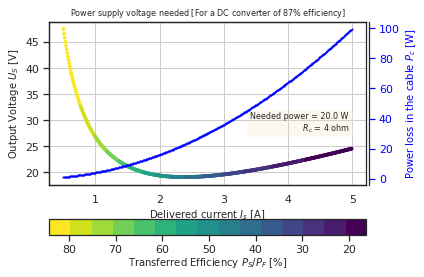

In [5]:
Rc=4 # Cable resistance back and forth
pf=4*5 # FPGA power
fl=1/0.88 # DC/DC converter factor

Is=np.arange(0.5,5,0.01) # all possible currents provided from the source

Us, Trans_eff = voltagesupply(pf=pf,fl=fl,Is=Is,Rc=Rc) # gives source potential and Transmited power (PF/PS *100)
Pc = cablepowerloss(Is=Is,Rc=Rc) # Power Loss in the cables

DataFrame = pd.DataFrame({"Is":Is, "Us":Us,"efficiency":Trans_eff,"Pc":Pc})  
print(DataFrame[145:152])


p.plot_linear(Directory=Directory , PdfPages=PdfPages, x=Is,x_label=r'Delivered current $I_s$ [A]',y=Us,y_label="Output Voltage $U_S$ [V]",
               map=True,z=Trans_eff,z_label="Transferred Efficiency $P_S/P_F$ [%]",
              text=True,txt ="Needed power = %0.1f W \n $R_c$ = %i ohm"%(pf,Rc), 
              test= "Power_supply_voltage",p = [pf, fl,Rc],
              title="Power supply voltage needed [For a DC converter of %i$\%%$ efficiency]"%(1/fl*100),
              line= True, data_line=Pc)

##  Stage II calculations [PP3 To PP0]

2 source Voltage Us = 3.20 V for 2 Mops to achieve 2.00 V per Mops


AttributeError: 'NoneType' object has no attribute 'endStream'

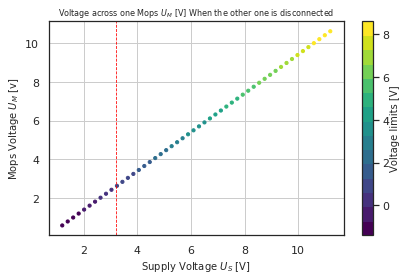

In [7]:
Um1= 2 # voltage across Mops <= 2V
Rc2=24 #ohm Cable resistance back and forth [PP3-PP0]
Id=0.025 #A Input current for 1 Mops Id=0.25m after simulation
Uc= Rc2*Id  # Voltage drop across the cable for one MOPS
Uc2=Rc2*Id*2 # Voltage drop across the cable for 2 Mops
Us2 = Uc2 + Um1 # Voltage needed from the power supply
print("2 source Voltage Us = %0.2f V for 2 Mops to achieve %0.2f V per Mops"%(Us2,Um1))
Us_space = np.linspace(Us2-2,Us2+8)
Uc1=Rc2*Id*1 #UC with 1 Mops
Um2= Us_space - Uc1
Limit =Um2-Um1
p.plot_lines(x1= Us_space ,y1 = Um2 ,z1=Limit,Directory=Directory,PdfPages=PdfPages)

p.close(PdfPages=PdfPages)